In [1]:
# load libraries
import os
import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et
from matplotlib import cm

# print current working directory
os.getcwd()

'/Users/chasedawson/dev/uva_equity_center/climate_equity'

In [36]:
# plot simple basemap with the coordinates of Charlottesville, VA
lat = 38.0293
lng = -78.4767
m = folium.Map(location=[lat, lng])
m

In [35]:
# change basemap with tiles parameter of Map() function
m = folium.Map(location=[lat, lng], tiles="Stamen Terrain")
m

In [5]:
# raster overlay on interactive map

# default coordinate system and projection for web-based basemaps in WGS84 Web Mercator
# to overlay a raster on a basemap, first project the raster to WGS84 (EPSG 4326)
dst_crs = 'EPSG:4326'

# read and reproject raster
path_to_st_cville = os.path.join("st_clipped", "st_cville.tif")
with rio.open(path_to_st_cville) as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # save reprojected raster 
    out_path = os.path.join("crs_espg_4326", "st_cville.tif")
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source = rio.band(src, i),
                destination = rio.band(dst, i),
                src_transformation = src.transform,
                src_crs = src.crs,
                dst_transform = transform,
                dst_crs = dst_crs,
                resampling = Resampling.nearest
            )

# read in reprojected data as img
with rio.open(out_path) as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata

In [6]:
nodata

0.0

In [7]:
# overlay raster on map
# create basemap
m = folium.Map(location=[lat, lng], tiles = "Stamen Terrain", zoom_start = 13)

# overlay raster using add_child()
m.add_child(folium.raster_layers.ImageOverlay(img[0], opacity=0.7, bounds = [[src.bounds[1], src.bounds[0]], [src.bounds[3], src.bounds[2]]]))

# display map
m

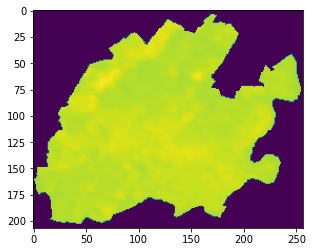

In [8]:
# plot just raster
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

f, ax = plt.subplots()
plt.imshow(img.squeeze())

In [9]:
# converting 0s to NaNs worked for plotting just the raster but not for plotting the raster on map with cmap

# change data type of array, must be float to include NaN
img = img.astype('float64')

# replace instances of 0 in array with NaN
img[img == 0.0] = np.nan

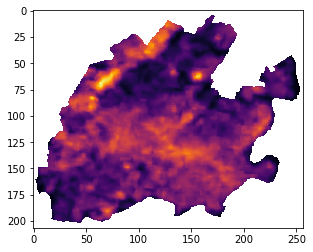

In [10]:
# replot, since 0s have been removed the only actual data is the data within cville boundary
f, ax = plt.subplots()
plt.imshow(img[0], cmap = cm.inferno)

In [28]:
print('Minimum: {min_}, Maximum: {max_}'.format(min_ = np.nanmin(img[0]), max_ = np.nanmax(img[0])))

Minimum: 43877.0, Maximum: 50667.0


In [31]:
def colorize(array, cmap='inferno'):
    normed_data = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data)

In [32]:
colored_img = colorize(img[0])

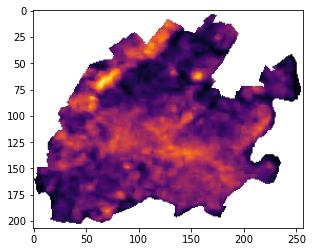

In [33]:
# replot, since 0s have been removed the only actual data is the data within cville boundary
f, ax = plt.subplots()
plt.imshow(colored_img)

In [37]:
# change colormap and handle nodata values
m = folium.Map(location=[lat, lng], tiles = "Stamen Terrain", zoom_start = 13)
overlay = folium.raster_layers.ImageOverlay(
    colored_img, 
    opacity = 0.7, 
    bounds = [[src.bounds[1], src.bounds[0]], [src.bounds[3], src.bounds[2]]],
)
overlay.add_to(m)
folium.LayerControl().add_to(m)
m

In [71]:
# References
# [Interactive Maps in Python](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/interactive-maps/)
# [Folium Notebooks: test_image_overlay_gulf_stream.ipynb](https://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_image_overlay_gulf_stream.ipynb)